In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [3]:
# os.chdir('..')
os.chdir('drive/My Drive/Colab Notebooks/Github/fashion-recommendations') 

In [4]:
from fashion_recommendations.metrics.average_precision import mapk

In [5]:
pd.options.display.max_columns = None

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [7]:
train_set_orig = pd.read_csv('data/splits/train_subset.tsv', sep='\t', dtype={'article_id': str})
print(train_set_orig.shape)
train_set_orig.head()

(588758, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0650193004,0.050831,1
3,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0527687006,0.101678,1
4,2018-09-20,02bfe1a5248beb9cd28ad4ac630a6d75e78d9a3e14551a...,0668767002,0.016932,2


In [8]:
test_set = pd.read_csv('data/splits/test_subset.tsv', sep='\t', dtype={'article_id': str})
print(test_set.shape)
test_set.head()

(32995, 5)


,t_dat,customer_id,article_id,price,sales_channel_id
0,2020-09-15,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007,0.061000,2
1,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010,0.033881,2
2,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0778745010,0.033881,2
3,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0610776105,0.008458,2
4,2020-09-15,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,0929745001,0.050831,2


In [9]:
customers = pd.read_csv('data/customers.csv')
print(customers.shape)
customers.head()

(1371980, 7)


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [10]:
customers.isnull().sum() / customers.shape[0]

customer_id               0.000000
FN                        0.652378
Active                    0.661508
club_member_status        0.004418
fashion_news_frequency    0.011669
age                       0.011561
postal_code               0.000000
dtype: float64

In [11]:
for col in customers:
    print(col)
    print(customers[col].unique())
    print('\n')

customer_id
['00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657'
 '0000423b00ade91418cceaf3b26c6af3dd342b51fd051eec9c12fb36984420fa'
 '000058a12d5b43e67d225668fa1f8d618c13dc232df0cad8ffe7ad4a1091e318' ...
 'ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264'
 'ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38b2236865d949d4df6a'
 'ffffd9ac14e89946416d80e791d064701994755c3ab686a1eaf3458c36f52241']


FN
[nan  1.]


Active
[nan  1.]


club_member_status
['ACTIVE' nan 'PRE-CREATE' 'LEFT CLUB']


fashion_news_frequency
['NONE' 'Regularly' nan 'Monthly' 'None']


age
[49. 25. 24. 54. 52. nan 20. 32. 29. 31. 56. 75. 41. 27. 30. 48. 35. 22.
 40. 38. 45. 68. 55. 19. 60. 44. 21. 26. 28. 53. 33. 17. 23. 51. 18. 34.
 57. 47. 70. 50. 63. 58. 43. 67. 72. 42. 39. 79. 71. 59. 36. 62. 37. 46.
 73. 64. 74. 61. 85. 69. 76. 66. 65. 82. 16. 90. 80. 78. 81. 84. 77. 97.
 89. 83. 98. 88. 86. 87. 93. 91. 99. 96. 94. 92. 95.]


postal_code
['52043ee2162cf5aa7ee79974281641c6f11a68d276429

- Impute NULLs in [`FN`, `Active`] with 0
- Lower case categories
- Replace `-` and spaces with `_`
- Impute `club_member_status` with `missing`
- Impute `fashion_news_frequency` with `missing`
- Mean imputation for `age` during training

In [12]:
customers[['FN', 'Active']] = customers[['FN', 'Active']].fillna(0)

In [13]:
customers['club_member_status'] = customers['club_member_status'].str.lower().str.replace('-', '_').str.replace(' ', '_').fillna('missing')

In [14]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].str.lower().str.replace('-', '_').str.replace(' ', '_').fillna('missing')

In [15]:
customers['fashion_news_frequency'] = customers['fashion_news_frequency'].replace('none', 'missing')

In [16]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,active,missing,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,active,missing,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,active,missing,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,active,missing,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,active,regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


### Map `customer_id` and `article_id` to indices

Test set doesn't include anyone not in training set

In [17]:
unique_customers_df = train_set_orig[['customer_id']].drop_duplicates().reset_index(drop=True)

customer_id_to_idx = dict(
    zip(
        unique_customers_df['customer_id'],
        unique_customers_df.index
    )
)

len(customer_id_to_idx)

9208

In [18]:
articles_df = pd.read_csv(
    'data/articles.csv', 
    dtype={'article_id': str}, 
#     usecols=['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'detail_desc']
)
print(articles_df.shape)
articles_df.head()

(105542, 25)


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,4,Dark,5,Black,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,3,Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,1,Dusty Light,9,White,1676,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,4,Dark,5,Black,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,3,Light,9,White,1339,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [19]:
articles_df['product_group_no'] = articles_df['product_group_name'].copy()

In [20]:
CATEGORICAL_FEATURES = [
    'product_code', 
    'product_type_no', 
    'product_group_no', 
    'graphical_appearance_no', 
    'colour_group_code', 
    'perceived_colour_value_id', 
    'perceived_colour_master_id', 
    'department_no', 
    'index_code', 
    'index_group_no', 
    'section_no', 
    'garment_group_no'
]

In [21]:
for cat in CATEGORICAL_FEATURES:
    print(cat)
    print(articles_df[cat].nunique())
    print('\n')

product_code
47224


product_type_no
132


product_group_no
19


graphical_appearance_no
30


colour_group_code
50


perceived_colour_value_id
8


perceived_colour_master_id
20


department_no
299


index_code
10


index_group_no
5


section_no
57


garment_group_no
21




In [22]:
cat_code_to_indices = {}

for cat in CATEGORICAL_FEATURES:
    cat_code_to_indices[cat] = {v: k for k, v in dict(enumerate(articles_df[cat].unique())).items()}

In [23]:
for cat in CATEGORICAL_FEATURES:
    articles_df[cat] = articles_df[cat].map(cat_code_to_indices[cat])

In [24]:
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,perceived_colour_value_id,perceived_colour_value_name,perceived_colour_master_id,perceived_colour_master_name,department_no,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc,product_group_no
0,0108775015,0,Strap top,0,Vest top,Garment Upper body,0,Solid,0,Black,0,Dark,0,Black,0,Jersey Basic,0,Ladieswear,0,Ladieswear,0,Womens Everyday Basics,0,Jersey Basic,Jersey top with narrow shoulder straps.,0
1,0108775044,0,Strap top,0,Vest top,Garment Upper body,0,Solid,1,White,1,Light,1,White,0,Jersey Basic,0,Ladieswear,0,Ladieswear,0,Womens Everyday Basics,0,Jersey Basic,Jersey top with narrow shoulder straps.,0
2,0108775051,0,Strap top (1),0,Vest top,Garment Upper body,1,Stripe,2,Off White,2,Dusty Light,1,White,0,Jersey Basic,0,Ladieswear,0,Ladieswear,0,Womens Everyday Basics,0,Jersey Basic,Jersey top with narrow shoulder straps.,0
3,0110065001,1,OP T-shirt (Idro),1,Bra,Underwear,0,Solid,0,Black,0,Dark,0,Black,1,Clean Lingerie,1,Lingeries/Tights,0,Ladieswear,1,Womens Lingerie,1,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",1
4,0110065002,1,OP T-shirt (Idro),1,Bra,Underwear,0,Solid,1,White,1,Light,1,White,1,Clean Lingerie,1,Lingeries/Tights,0,Ladieswear,1,Womens Lingerie,1,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde...",1


In [25]:
article_id_to_idx = dict(
    zip(
        articles_df['article_id'],
        articles_df.index
    )
)

In [26]:
articles_df['article_id_idx'] = articles_df['article_id'].map(article_id_to_idx)

In [27]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,active,missing,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,active,missing,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,active,missing,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,active,missing,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,active,regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [28]:
customers_cat_code_to_indices = {}

for cat in ['club_member_status', 'fashion_news_frequency', 'postal_code']:
    customers_cat_code_to_indices[cat] = {v: k for k, v in dict(enumerate(customers[cat].unique())).items()}

In [29]:
for cat in ['club_member_status', 'fashion_news_frequency', 'postal_code']:
    customers[cat] = customers[cat].map(customers_cat_code_to_indices[cat])

In [30]:
customers['customer_id_idx'] = customers['customer_id'].map(customer_id_to_idx)

In [31]:
customers.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,customer_id_idx
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,0,0,49.0,0,NaN
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,0,0,25.0,1,NaN
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,0,0,24.0,2,0.0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,0,0,54.0,3,NaN
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,0,1,52.0,4,NaN


In [32]:
train_set_orig['customer_id_idx'] = train_set_orig['customer_id'].map(customer_id_to_idx)
train_set_orig['article_id_idx'] = train_set_orig['article_id'].map(article_id_to_idx)

train_set_orig.head()

,t_dat,customer_id,article_id,price,sales_channel_id,customer_id_idx,article_id_idx
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,0,40179
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2,0,10520
2,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0650193004,0.050831,1,1,36302
3,2018-09-20,016d8f0519d9e0572b3abebeab87408bad7a5c3a284016...,0527687006,0.101678,1,1,8963
4,2018-09-20,02bfe1a5248beb9cd28ad4ac630a6d75e78d9a3e14551a...,0668767002,0.016932,2,2,41390


Merge article features

In [33]:
train_set_orig = train_set_orig.merge(
    articles_df[['article_id_idx'] + CATEGORICAL_FEATURES], 
    on='article_id_idx', 
    how='inner'
)

In [34]:
train_set_orig.head()

,t_dat,customer_id,article_id,price,sales_channel_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,0,40179,16361,65,1,0,0,0,0,47,1,0,1,1
1,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,0,40179,16361,65,1,0,0,0,0,47,1,0,1,1
2,2018-10-26,8256c9d0a398717ab5f575acfa5184a11ab1a1e89f7fbc...,0663713001,0.048288,1,2480,40179,16361,65,1,0,0,0,0,47,1,0,1,1
3,2018-11-02,b333b5b934a0a54154ec46a352ba16a3e0fb7815cb46dc...,0663713001,0.050831,2,3856,40179,16361,65,1,0,0,0,0,47,1,0,1,1
4,2018-12-09,6cebb7f0bf845b15e8926474096ce615874ec23e7fb59e...,0663713001,0.050831,2,2087,40179,16361,65,1,0,0,0,0,47,1,0,1,1


In [35]:
train_set_orig.drop(columns=['price', 'sales_channel_id'], inplace=True)

Merge customer features

In [36]:
train_set_orig.shape

(588758, 17)

In [37]:
train_set_orig = train_set_orig.merge(
    customers.drop(columns='customer_id'),
    on='customer_id_idx'
)

In [38]:
train_set_orig.head()

,t_dat,customer_id,article_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0,40179,16361,65,1,0,0,0,0,47,1,0,1,1,0.0,0.0,0,0,24.0,2
1,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0,40179,16361,65,1,0,0,0,0,47,1,0,1,1,0.0,0.0,0,0,24.0,2
2,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0,10520,3431,1,1,0,16,2,5,4,1,0,1,1,0.0,0.0,0,0,24.0,2
3,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0351484002,0,1469,383,20,10,0,0,0,0,21,1,0,14,8,0.0,0.0,0,0,24.0,2
4,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0351484002,0,1469,383,20,10,0,0,0,0,21,1,0,14,8,0.0,0.0,0,0,24.0,2


### Create example age and time-related features

In [39]:
train_set_orig['t_dat'] = pd.to_datetime(train_set_orig['t_dat'])

In [40]:
end = train_set_orig['t_dat'].max()
endm1 = end - datetime.timedelta(days=7)

endm1, end

(Timestamp('2020-09-07 00:00:00'), Timestamp('2020-09-14 00:00:00'))

In [41]:
train_set_orig['example_age'] = (end - train_set_orig['t_dat']).dt.days

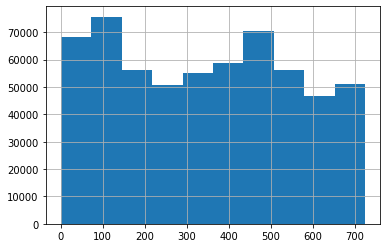

In [42]:
train_set_orig['example_age'].hist()

In [43]:
train_set_orig['t_dat_quarter'] = train_set_orig['t_dat'].dt.quarter

In [44]:
train_set_orig = pd.get_dummies(train_set_orig, columns=['t_dat_quarter'])

In [45]:
train_set_orig.head()

,t_dat,customer_id,article_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,example_age,t_dat_quarter_1,t_dat_quarter_2,t_dat_quarter_3,t_dat_quarter_4
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0,40179,16361,65,1,0,0,0,0,47,1,0,1,1,0.0,0.0,0,0,24.0,2,725,0,0,1,0
1,2018-09-24,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0,40179,16361,65,1,0,0,0,0,47,1,0,1,1,0.0,0.0,0,0,24.0,2,721,0,0,1,0
2,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0,10520,3431,1,1,0,16,2,5,4,1,0,1,1,0.0,0.0,0,0,24.0,2,725,0,0,1,0
3,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0351484002,0,1469,383,20,10,0,0,0,0,21,1,0,14,8,0.0,0.0,0,0,24.0,2,224,1,0,0,0
4,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0351484002,0,1469,383,20,10,0,0,0,0,21,1,0,14,8,0.0,0.0,0,0,24.0,2,224,1,0,0,0


### Create development set

In [46]:
# Remove customers from dev set who are not in the new training set
customers_to_remove = (
    set(train_set_orig[train_set_orig['t_dat'] >= endm1]['customer_id']) - 
    set(train_set_orig[train_set_orig['t_dat'] < endm1]['customer_id'])
)

In [47]:
len(customers_to_remove)

60

In [48]:
train_set = train_set_orig.copy()[train_set_orig['t_dat'] < endm1]

dev_set = train_set_orig.copy()[train_set_orig['t_dat'] >= endm1]

train_set.shape, dev_set.shape

((580395, 28), (8363, 28))

In [49]:
dev_set = dev_set.copy()[~dev_set['customer_id'].isin(customers_to_remove)]
print(dev_set.shape)
dev_set.head()

(8131, 28)


,t_dat,customer_id,article_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,example_age,t_dat_quarter_1,t_dat_quarter_2,t_dat_quarter_3,t_dat_quarter_4
270,2020-09-08,6cebb7f0bf845b15e8926474096ce615874ec23e7fb59e...,0879605001,2087,98504,42861,21,1,0,0,0,0,16,7,4,9,1,0.0,0.0,0,0,49.0,76294,6,0,0,1,0
356,2020-09-12,e55d65809939bdc0e612404523492e113623d4db936d83...,0767423001,5435,72351,30052,5,0,0,1,1,1,127,7,4,25,9,0.0,0.0,0,0,28.0,17065,2,0,0,1,0
367,2020-09-12,e55d65809939bdc0e612404523492e113623d4db936d83...,0752814018,5435,67951,28101,7,3,3,3,2,2,48,0,0,21,11,0.0,0.0,0,0,28.0,17065,2,0,0,1,0
371,2020-09-12,e55d65809939bdc0e612404523492e113623d4db936d83...,0895610001,5435,101302,44484,7,3,0,34,3,2,90,0,0,32,11,0.0,0.0,0,0,28.0,17065,2,0,0,1,0
372,2020-09-12,e55d65809939bdc0e612404523492e113623d4db936d83...,0895610001,5435,101302,44484,7,3,0,34,3,2,90,0,0,32,11,0.0,0.0,0,0,28.0,17065,2,0,0,1,0


In [50]:
dev_set_by_customer = dev_set.groupby('customer_id').apply(lambda x: list(x['article_id_idx'])).reset_index().rename(columns={0: 'article_id_idx'})
dev_set_by_customer.head()

,customer_id,article_id_idx
0,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,[102443]
1,0054c50274d19af58d53ef3ce0c004bea446c80bd51cf2...,"[71167, 72000, 16023]"
2,00639e775b90554156986100685c4d408723c77e411e37...,"[100645, 100645, 100648]"
3,00798bd464457d23d6af401715fe32d5c676ad9ee4010d...,[103885]
4,0099238196d8f71659fceaa115b36e400398bcfc169b5f...,"[3091, 49553, 49553, 99182, 99182, 95789, 9578..."


In [51]:
customer_id_idx_ordered = dev_set_by_customer['customer_id'].map(customer_id_to_idx).tolist()

In [52]:
dev_actuals = dev_set_by_customer['article_id_idx'].to_list()

### Explore transactions

Only include articles bought after 2020-01:

In [53]:
article_id_idx_to_keep = train_set[train_set['t_dat'] > '2020-01-01']['article_id_idx'].unique()

In [54]:
print(train_set.shape)
train_set = train_set.copy()[train_set['article_id_idx'].isin(article_id_idx_to_keep)]
print(train_set.shape)

(580395, 28)
(386503, 28)


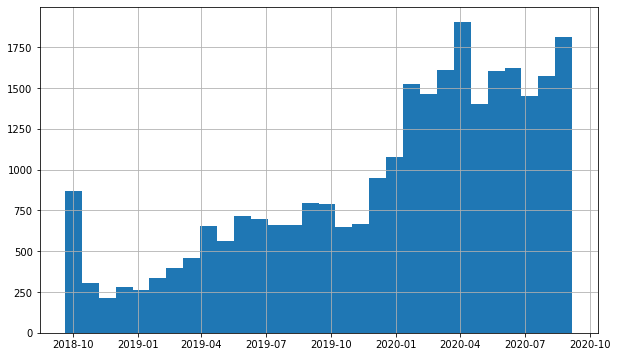

In [55]:
# First recorded transaction for each item
plt.figure(figsize=(10, 6))
train_set.groupby('article_id_idx')['t_dat'].min().hist(bins=30)
plt.show()

Can see that even though we restrict items to after 2020 some were available before then

### Format data

Since all the users in the test said are included in training we utilise the full training set.

In [56]:
train_set.head()

,t_dat,customer_id,article_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,example_age,t_dat_quarter_1,t_dat_quarter_2,t_dat_quarter_3,t_dat_quarter_4
3,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0351484002,0,1469,383,20,10,0,0,0,0,21,1,0,14,8,0.0,0.0,0,0,24.0,2,224,1,0,0,0
4,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0351484002,0,1469,383,20,10,0,0,0,0,21,1,0,14,8,0.0,0.0,0,0,24.0,2,224,1,0,0,0
6,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0723529001,0,59458,24374,19,10,0,0,0,0,21,1,0,14,8,0.0,0.0,0,0,24.0,2,224,1,0,0,0
7,2020-04-01,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0727808001,0,60253,24801,5,0,0,0,0,0,96,3,2,20,9,0.0,0.0,0,0,24.0,2,166,0,1,0,0
8,2020-04-01,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0727808007,0,60259,24801,5,0,3,5,3,3,96,3,2,20,9,0.0,0.0,0,0,24.0,2,166,0,1,0,0


- Keep distinct purchases only
- Discard date, price and channel columns

In [57]:
endm1

Timestamp('2020-09-07 00:00:00')

In [58]:
# # Latest transactions only
# train_set = train_set.copy()[train_set['t_dat'] > endm1 - datetime.timedelta(days=7*52)]

In [59]:
train_set.shape

(386503, 28)

In [60]:
# train_set_processed = train_set.copy().drop(columns=['t_dat']).drop_duplicates()
train_set_processed = train_set.copy()
train_set_processed.shape

(386503, 28)

In [61]:
train_set_processed.head()

,t_dat,customer_id,article_id,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,example_age,t_dat_quarter_1,t_dat_quarter_2,t_dat_quarter_3,t_dat_quarter_4
3,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0351484002,0,1469,383,20,10,0,0,0,0,21,1,0,14,8,0.0,0.0,0,0,24.0,2,224,1,0,0,0
4,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0351484002,0,1469,383,20,10,0,0,0,0,21,1,0,14,8,0.0,0.0,0,0,24.0,2,224,1,0,0,0
6,2020-02-03,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0723529001,0,59458,24374,19,10,0,0,0,0,21,1,0,14,8,0.0,0.0,0,0,24.0,2,224,1,0,0,0
7,2020-04-01,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0727808001,0,60253,24801,5,0,0,0,0,0,96,3,2,20,9,0.0,0.0,0,0,24.0,2,166,0,1,0,0
8,2020-04-01,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0727808007,0,60259,24801,5,0,3,5,3,3,96,3,2,20,9,0.0,0.0,0,0,24.0,2,166,0,1,0,0


For each customer sample up to X non-purchased items to use as negative samples

In [62]:
train_set.copy().drop(columns=['t_dat']).drop_duplicates().groupby(['customer_id_idx'])['article_id_idx'].apply(lambda x: list(x)).reset_index().shape

(9052, 2)

In [63]:
purchases_by_customer_id_idx = train_set_processed.groupby(['customer_id_idx', 't_dat'])['article_id_idx'].apply(lambda x: list(x)).reset_index()
print(purchases_by_customer_id_idx.shape)
purchases_by_customer_id_idx.head()

(132850, 3)


,customer_id_idx,t_dat,article_id_idx
0,0,2020-02-03,"[1469, 1469, 59458]"
1,0,2020-04-01,"[60253, 60259]"
2,0,2020-04-18,"[91841, 93585, 92158, 92159, 67274, 67274, 963..."
3,1,2019-05-25,"[15137, 74821]"
4,1,2019-06-06,[50471]


In [64]:
purchases_by_customer_id_idx = purchases_by_customer_id_idx.groupby('customer_id_idx').sample(n=1)

In [65]:
top100_items = (train_set.groupby('article_id_idx')['customer_id'].count() / train_set.shape[0]).sort_values(ascending=False).head(1000).index.tolist()
top100_items

[53892,
 53893,
 1713,
 24837,
 70221,
 3091,
 42626,
 24836,
 1714,
 67522,
 58491,
 2236,
 67,
 42557,
 53894,
 73,
 3711,
 24266,
 17383,
 16003,
 14253,
 14240,
 75,
 53902,
 44032,
 81824,
 2252,
 81825,
 18586,
 75912,
 55588,
 1469,
 74,
 367,
 115,
 8,
 49923,
 47295,
 47592,
 46351,
 72734,
 4444,
 9916,
 9,
 70220,
 22923,
 12585,
 81826,
 80920,
 49922,
 53896,
 6641,
 56692,
 32742,
 3088,
 46382,
 64367,
 67052,
 17043,
 46426,
 2255,
 14246,
 74740,
 17044,
 67051,
 45791,
 74739,
 851,
 22640,
 57643,
 25068,
 71097,
 57399,
 20850,
 9773,
 15137,
 15988,
 68263,
 28967,
 47298,
 22656,
 67943,
 14254,
 46425,
 61602,
 26967,
 79832,
 60746,
 78964,
 40283,
 14931,
 45568,
 121,
 17155,
 90083,
 51504,
 56694,
 48707,
 71103,
 176,
 2865,
 87467,
 22648,
 18503,
 38186,
 11436,
 74742,
 17164,
 70114,
 0,
 56691,
 45795,
 46384,
 76457,
 12724,
 18294,
 2243,
 81828,
 47593,
 59432,
 73698,
 958,
 90082,
 47080,
 71102,
 2246,
 12598,
 17125,
 57978,
 62482,
 25071,
 226

In [66]:
def negative_samples(excl):
    # samples = set(np.random.choice(len(article_id_to_idx), replace=False, size=1000))
    samples = set(np.random.choice(article_id_idx_to_keep, replace=False, size=2000))
    # samples = set(np.random.choice(top100_items, replace=False, size=1000))
    neg_samples = samples - set(excl)
    return list(neg_samples)

In [67]:
# negative_samples(purchases_by_customer_id_idx.iloc[0]['article_id_idx'])

In [68]:
%%time
purchases_by_customer_id_idx['negative_samples'] = purchases_by_customer_id_idx['article_id_idx'].apply(negative_samples)

CPU times: user 7.05 s, sys: 282 ms, total: 7.33 s
Wall time: 7.46 s


In [69]:
purchases_by_customer_id_idx.head()

,customer_id_idx,t_dat,article_id_idx,negative_samples
2,0,2020-04-18,"[91841, 93585, 92158, 92159, 67274, 67274, 963...","[81921, 73729, 98307, 16390, 98311, 81933, 163..."
17,1,2020-07-03,"[97301, 97303, 97302, 102945]","[77824, 81921, 73729, 73733, 86030, 94223, 102..."
45,2,2020-08-02,"[57064, 70911, 95256, 95256, 100981, 70916]","[32772, 81925, 73736, 102413, 86030, 12303, 20..."
48,3,2018-09-20,"[14832, 17669]","[77824, 65543, 98313, 73739, 57358, 94223, 614..."
73,4,2019-08-14,[64817],"[86017, 53250, 94216, 12303, 81938, 16404, 819..."


In [70]:
purchases_by_customer_id_idx['negative_samples'].apply(len).value_counts()

2000    7530
1999    1337
1998     153
1997      24
1996       5
1995       3
Name: negative_samples, dtype: int64

In [71]:
negative_samples_df = purchases_by_customer_id_idx[['customer_id_idx', 't_dat', 'negative_samples']].explode('negative_samples')
negative_samples_df.head()

,customer_id_idx,t_dat,negative_samples
2,0,2020-04-18,81921
2,0,2020-04-18,73729
2,0,2020-04-18,98307
2,0,2020-04-18,16390
2,0,2020-04-18,98311


In [72]:
negative_samples_df.isnull().sum()

customer_id_idx     0
t_dat               0
negative_samples    0
dtype: int64

In [73]:
negative_samples_df.dropna(subset=['negative_samples'], inplace=True)

In [74]:
negative_samples_df.rename(columns={'negative_samples': 'article_id_idx'}, inplace=True)
negative_samples_df['purchased'] = 0

In [75]:
print(negative_samples_df.shape)
negative_samples_df.head()

(18102250, 4)


,customer_id_idx,t_dat,article_id_idx,purchased
2,0,2020-04-18,81921,0
2,0,2020-04-18,73729,0
2,0,2020-04-18,98307,0
2,0,2020-04-18,16390,0
2,0,2020-04-18,98311,0


In [76]:
negative_samples_df = negative_samples_df.merge(articles_df[['article_id_idx'] + CATEGORICAL_FEATURES], on='article_id_idx')
negative_samples_df = negative_samples_df.merge(
    customers.drop(columns='customer_id'),
    on='customer_id_idx'
)
print(negative_samples_df.shape)
negative_samples_df.head()

(18102250, 22)


,customer_id_idx,t_dat,article_id_idx,purchased,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,0,2020-04-18,81921,0,34587,32,9,10,3,2,2,157,4,0,31,7,0.0,0.0,0,0,24.0,2
1,0,2020-04-18,73729,0,30671,56,4,0,15,4,10,38,4,0,6,4,0.0,0.0,0,0,24.0,2
2,0,2020-04-18,98307,0,42754,5,0,0,2,2,1,112,7,4,33,3,0.0,0.0,0,0,24.0,2
3,0,2020-04-18,16390,0,5734,24,0,0,0,0,0,123,3,2,4,0,0.0,0.0,0,0,24.0,2
4,0,2020-04-18,98311,0,42756,23,3,8,4,2,2,278,7,4,52,11,0.0,0.0,0,0,24.0,2


In [77]:
negative_samples_df['example_age'] = (end - negative_samples_df['t_dat']).dt.days

In [78]:
negative_samples_df['t_dat_quarter'] = negative_samples_df['t_dat'].dt.quarter

In [79]:
negative_samples_df = pd.get_dummies(negative_samples_df, columns=['t_dat_quarter'])

In [80]:
negative_samples_df.drop(columns=['t_dat'], inplace=True)

In [81]:
print(negative_samples_df.shape)
negative_samples_df.head()

(18102250, 26)


,customer_id_idx,article_id_idx,purchased,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,example_age,t_dat_quarter_1,t_dat_quarter_2,t_dat_quarter_3,t_dat_quarter_4
0,0,81921,0,34587,32,9,10,3,2,2,157,4,0,31,7,0.0,0.0,0,0,24.0,2,149,0,1,0,0
1,0,73729,0,30671,56,4,0,15,4,10,38,4,0,6,4,0.0,0.0,0,0,24.0,2,149,0,1,0,0
2,0,98307,0,42754,5,0,0,2,2,1,112,7,4,33,3,0.0,0.0,0,0,24.0,2,149,0,1,0,0
3,0,16390,0,5734,24,0,0,0,0,0,123,3,2,4,0,0.0,0.0,0,0,24.0,2,149,0,1,0,0
4,0,98311,0,42756,23,3,8,4,2,2,278,7,4,52,11,0.0,0.0,0,0,24.0,2,149,0,1,0,0


In [82]:
positive_samples_df = train_set_processed.copy().drop(columns=['customer_id', 'article_id', 't_dat'])
positive_samples_df['purchased'] = 1

print(positive_samples_df.shape)
positive_samples_df.head()

(386503, 26)


,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,example_age,t_dat_quarter_1,t_dat_quarter_2,t_dat_quarter_3,t_dat_quarter_4,purchased
3,0,1469,383,20,10,0,0,0,0,21,1,0,14,8,0.0,0.0,0,0,24.0,2,224,1,0,0,0,1
4,0,1469,383,20,10,0,0,0,0,21,1,0,14,8,0.0,0.0,0,0,24.0,2,224,1,0,0,0,1
6,0,59458,24374,19,10,0,0,0,0,21,1,0,14,8,0.0,0.0,0,0,24.0,2,224,1,0,0,0,1
7,0,60253,24801,5,0,0,0,0,0,96,3,2,20,9,0.0,0.0,0,0,24.0,2,166,0,1,0,0,1
8,0,60259,24801,5,0,3,5,3,3,96,3,2,20,9,0.0,0.0,0,0,24.0,2,166,0,1,0,0,1


In [83]:
training_data_full = positive_samples_df.append(negative_samples_df)
training_data_full.shape

(18488753, 26)

In [84]:
del positive_samples_df, negative_samples_df

In [85]:
training_data_full['purchased'].mean()

0.020904763019983015

In [86]:
training_data_full.head()

,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,example_age,t_dat_quarter_1,t_dat_quarter_2,t_dat_quarter_3,t_dat_quarter_4,purchased
3,0,1469,383,20,10,0,0,0,0,21,1,0,14,8,0.0,0.0,0,0,24.0,2,224,1,0,0,0,1
4,0,1469,383,20,10,0,0,0,0,21,1,0,14,8,0.0,0.0,0,0,24.0,2,224,1,0,0,0,1
6,0,59458,24374,19,10,0,0,0,0,21,1,0,14,8,0.0,0.0,0,0,24.0,2,224,1,0,0,0,1
7,0,60253,24801,5,0,0,0,0,0,96,3,2,20,9,0.0,0.0,0,0,24.0,2,166,0,1,0,0,1
8,0,60259,24801,5,0,3,5,3,3,96,3,2,20,9,0.0,0.0,0,0,24.0,2,166,0,1,0,0,1


Create another dev split to measure classification loss during training

In [87]:
from sklearn.model_selection import train_test_split

In [88]:
training_data_full, dev_data_full = train_test_split(training_data_full, test_size=0.3)

In [89]:
from sklearn.impute import SimpleImputer

In [90]:
imp_mean = SimpleImputer()

In [91]:
imp_mean.fit(training_data_full['age'].values.reshape(-1, 1))

SimpleImputer()

In [92]:
training_data_full['age'] = imp_mean.transform(training_data_full['age'].values.reshape(-1, 1))
dev_data_full['age'] = imp_mean.transform(dev_data_full['age'].values.reshape(-1, 1))

In [93]:
from sklearn.preprocessing import MinMaxScaler

In [94]:
scaler = MinMaxScaler()

In [95]:
scaler.fit(training_data_full[['age', 'example_age']])

MinMaxScaler()

In [96]:
training_data_full[['age', 'example_age']] = scaler.transform(training_data_full[['age', 'example_age']])
dev_data_full[['age', 'example_age']] = scaler.transform(dev_data_full[['age', 'example_age']])

In [97]:
training_data_full.head()

,customer_id_idx,article_id_idx,product_code,product_type_no,product_group_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,example_age,t_dat_quarter_1,t_dat_quarter_2,t_dat_quarter_3,t_dat_quarter_4,purchased
15473504,6695,21642,8078,5,0,0,13,2,9,136,0,0,21,3,1.0,1.0,0,1,0.028169,17407,0.736402,1,0,0,0,0
5123952,5391,57612,23568,0,0,0,13,2,9,23,7,4,9,0,0.0,0.0,0,0,0.098592,107402,0.142259,0,1,0,0,0
2219819,7784,98719,42980,13,7,0,4,3,8,1,1,0,1,1,0.0,0.0,0,0,0.323944,329549,0.486750,0,0,1,0,0
7101320,6983,50855,20648,29,0,1,26,4,7,148,7,4,25,17,1.0,1.0,0,1,0.267606,74409,0.154812,0,1,0,0,0
5287893,6784,60829,25017,24,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0,1,0.056338,107864,0.495119,0,0,1,0,0


In [98]:
NUMERIC_FEATURES = [
    'FN', 
    'Active', 
    'age', 
    'example_age', 
    't_dat_quarter_1', 
    't_dat_quarter_2', 
    't_dat_quarter_3', 
    't_dat_quarter_4'
]

In [99]:
class PurchasesDatasetWithArticleFeatures(Dataset):

    def __init__(self, df):
        self.customer_id_idx = df['customer_id_idx'].values
        self.article_id_idx = df['article_id_idx'].values
        self.product_code = df['product_code'].values
        self.product_type_no = df['product_type_no'].values
        self.product_group_no = df['product_group_no'].values
        self.graphical_appearance_no = df['graphical_appearance_no'].values
        self.colour_group_code = df['colour_group_code'].values
        self.perceived_colour_value_id = df['perceived_colour_value_id'].values
        self.perceived_colour_master_id = df['perceived_colour_master_id'].values
        self.department_no = df['department_no'].values
        self.index_code = df['index_code'].values
        self.index_group_no = df['index_group_no'].values
        self.section_no = df['section_no'].values
        self.garment_group_no = df['garment_group_no'].values
        
        self.club_member_status = df['club_member_status'].values
        self.fashion_news_frequency = df['fashion_news_frequency'].values
        self.postal_code = df['postal_code'].values
        self.numeric_features = df[NUMERIC_FEATURES].values
        
        self.purchased = df['purchased'].values

    def __len__(self):
        return self.customer_id_idx.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        return (
            self.customer_id_idx[idx],
            self.article_id_idx[idx],
            self.product_code[idx],
            self.product_type_no[idx],
            self.product_group_no[idx],
            self.graphical_appearance_no[idx],
            self.colour_group_code[idx],
            self.perceived_colour_value_id[idx],
            self.perceived_colour_master_id[idx],
            self.department_no[idx],
            self.index_code[idx],
            self.index_group_no[idx],
            self.section_no[idx],
            self.garment_group_no[idx],
            self.club_member_status[idx],
            self.fashion_news_frequency[idx],
            self.postal_code[idx],
            self.numeric_features[idx],
            self.purchased[idx]
        )

In [100]:
train_dataset = PurchasesDatasetWithArticleFeatures(training_data_full)
dev_dataset = PurchasesDatasetWithArticleFeatures(dev_data_full)

In [101]:
BATCH_SIZE = 2048

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)  
dev_loader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)  

In [102]:
# # Selecting a subset of data
# subset = torch.utils.data.Subset(train_dataset, [1])

# train_loader = DataLoader(subset, batch_size=BATCH_SIZE)  

In [103]:
class FashionRecV2(nn.Module):

    def __init__(self, embedding_dim):
        super(FashionRecV2, self).__init__()
        
        # Embeddings
        self.user_embeddings = nn.Embedding(num_embeddings=len(customer_id_to_idx), embedding_dim=embedding_dim)        
        self.item_embeddings = nn.Embedding(num_embeddings=len(article_id_to_idx), embedding_dim=embedding_dim)
        self.product_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_code']), embedding_dim=embedding_dim)
        self.product_type_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_type_no']), embedding_dim=embedding_dim)
        self.product_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['product_group_no']), embedding_dim=embedding_dim)
        self.graphical_appearance_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['graphical_appearance_no']), embedding_dim=embedding_dim)
        self.colour_group_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['colour_group_code']), embedding_dim=embedding_dim)
        self.perceived_colour_value_id_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['perceived_colour_value_id']), embedding_dim=embedding_dim)
        self.perceived_colour_master_id_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['perceived_colour_master_id']), embedding_dim=embedding_dim)
        self.department_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['department_no']), embedding_dim=embedding_dim)
        self.index_code_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['index_code']), embedding_dim=embedding_dim)
        self.index_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['index_group_no']), embedding_dim=embedding_dim)
        self.section_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['section_no']), embedding_dim=embedding_dim)
        self.garment_group_no_embeddings = nn.Embedding(num_embeddings=len(cat_code_to_indices['garment_group_no']), embedding_dim=embedding_dim)
        
        self.club_member_status_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['club_member_status']), embedding_dim=embedding_dim)
        self.fashion_news_frequency_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['fashion_news_frequency']), embedding_dim=embedding_dim)
        self.postal_code_embeddings = nn.Embedding(num_embeddings=len(customers_cat_code_to_indices['postal_code']), embedding_dim=embedding_dim)

        # Initialise embeddings
        torch.nn.init.xavier_uniform_(self.user_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.item_embeddings.weight)        
        torch.nn.init.xavier_uniform_(self.product_code_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.product_type_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.product_group_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.graphical_appearance_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.colour_group_code_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.perceived_colour_value_id_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.perceived_colour_master_id_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.department_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.index_code_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.index_group_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.section_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.garment_group_no_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.club_member_status_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.fashion_news_frequency_embeddings.weight)
        torch.nn.init.xavier_uniform_(self.postal_code_embeddings.weight)
        
        # FC layers
        self.fc_1 = nn.Linear(in_features=embedding_dim*17+len(NUMERIC_FEATURES), out_features=500)            
        self.fc_2 = nn.Linear(in_features=500, out_features=250)
        # self.fc_3 = nn.Linear(in_features=500, out_features=250)        
        self.fc_3 = nn.Linear(in_features=250, out_features=1)
        
        # Activation functions
        self.relu = nn.ReLU()        
        self.sigmoid = nn.Sigmoid()
        
        # Dropout
        self.dropout = nn.Dropout(0.2)
        
    def forward(
        self, 
        user_id, 
        item_id,
        product_code, 
        product_type_no, 
        product_group_no, 
        graphical_appearance_no, 
        colour_group_code, 
        perceived_colour_value_id, 
        perceived_colour_master_id, 
        department_no, 
        index_code, 
        index_group_no, 
        section_no, 
        garment_group_no,
        club_member_status,
        fashion_news_frequency,
        postal_code,
        numeric_features,
    ):

        user_emb = self.user_embeddings(user_id)
        item_emb = self.item_embeddings(item_id)
        product_code_emb = self.product_code_embeddings(product_code)
        product_type_no_emb = self.product_type_no_embeddings(product_type_no)
        product_group_no_emb = self.product_group_no_embeddings(product_group_no)
        graphical_appearance_no_emb = self.graphical_appearance_no_embeddings(graphical_appearance_no)
        colour_group_code_emb = self.colour_group_code_embeddings(colour_group_code)
        perceived_colour_value_id_emb = self.perceived_colour_value_id_embeddings(perceived_colour_value_id)
        perceived_colour_master_id_emb = self.perceived_colour_master_id_embeddings(perceived_colour_master_id)
        department_no_emb = self.department_no_embeddings(department_no)
        index_code_emb = self.index_code_embeddings(index_code)
        index_group_no_emb = self.index_group_no_embeddings(index_group_no)
        section_no_emb = self.section_no_embeddings(section_no)
        garment_group_no_emb = self.garment_group_no_embeddings(garment_group_no)
        
        club_member_status_emb = self.club_member_status_embeddings(club_member_status)
        fashion_news_frequency_emb = self.fashion_news_frequency_embeddings(fashion_news_frequency)
        postal_code_emb = self.postal_code_embeddings(postal_code)
              
        concatenated_emb = torch.concat(
            [
                user_emb, 
                item_emb,
                product_code_emb,
                product_type_no_emb,
                product_group_no_emb,
                graphical_appearance_no_emb,
                colour_group_code_emb,
                perceived_colour_value_id_emb,
                perceived_colour_master_id_emb,
                department_no_emb,
                index_code_emb,
                index_group_no_emb,
                section_no_emb,
                garment_group_no_emb,
                club_member_status_emb,
                fashion_news_frequency_emb,
                postal_code_emb,
                numeric_features
            ], 
            dim=1
        )
        
        x = self.fc_1(concatenated_emb)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc_3(x)
        x = self.sigmoid(x)

        return x

In [104]:
fashion_rec_v2 = FashionRecV2(embedding_dim=32)

In [105]:
fashion_rec_v2.to(device)

FashionRecV2(
  (user_embeddings): Embedding(9208, 32)
  (item_embeddings): Embedding(105542, 32)
  (product_code_embeddings): Embedding(47224, 32)
  (product_type_no_embeddings): Embedding(132, 32)
  (product_group_no_embeddings): Embedding(19, 32)
  (graphical_appearance_no_embeddings): Embedding(30, 32)
  (colour_group_code_embeddings): Embedding(50, 32)
  (perceived_colour_value_id_embeddings): Embedding(8, 32)
  (perceived_colour_master_id_embeddings): Embedding(20, 32)
  (department_no_embeddings): Embedding(299, 32)
  (index_code_embeddings): Embedding(10, 32)
  (index_group_no_embeddings): Embedding(5, 32)
  (section_no_embeddings): Embedding(57, 32)
  (garment_group_no_embeddings): Embedding(21, 32)
  (club_member_status_embeddings): Embedding(4, 32)
  (fashion_news_frequency_embeddings): Embedding(3, 32)
  (postal_code_embeddings): Embedding(352899, 32)
  (fc_1): Linear(in_features=552, out_features=500, bias=True)
  (fc_2): Linear(in_features=500, out_features=250, bias=True

In [106]:
# fashion_rec_v2(torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), torch.tensor([0]), )

In [107]:
optimizer = torch.optim.Adam(params=fashion_rec_v2.parameters(), lr=0.0001)

Switched to BCELoss instead of weighted MSE. Had more success with this.

In [108]:
criterion = nn.BCELoss()

In [109]:
MAX_EPOCHS = 7
training_losses = []
dev_losses = []

for epoch in range(MAX_EPOCHS):
    
    for data in tqdm(train_loader):
        
        user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data
        
        user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
            user_id.to(device), 
            item_id.to(device), 
            product_code.to(device), 
            product_type_no.to(device), 
            product_group_no.to(device), 
            graphical_appearance_no.to(device), 
            colour_group_code.to(device), 
            perceived_colour_value_id.to(device), 
            perceived_colour_master_id.to(device), 
            department_no.to(device), 
            index_code.to(device), 
            index_group_no.to(device), 
            section_no.to(device), 
            garment_group_no.to(device), 
            club_member_status.to(device), 
            fashion_news_frequency.to(device), 
            postal_code.to(device), 
            numeric_features.to(device),
            label.to(device)
        )    

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        pred = fashion_rec_v2(
            user_id, 
            item_id, 
            product_code, 
            product_type_no, 
            product_group_no, 
            graphical_appearance_no, 
            colour_group_code, 
            perceived_colour_value_id, 
            perceived_colour_master_id, 
            department_no, 
            index_code, 
            index_group_no, 
            section_no, 
            garment_group_no,
            club_member_status,
            fashion_news_frequency,
            postal_code,
            numeric_features.float()
        )

        loss = criterion(pred.flatten(), label.float())

        loss.backward()  
        
        optimizer.step()
        
    # Compute training loss
    
    total_train_loss = 0

    fashion_rec_v2.eval()

    with torch.no_grad():
        for data in tqdm(DataLoader(train_dataset, batch_size=BATCH_SIZE*4)):
            
            user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data

            user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
                user_id.to(device), 
                item_id.to(device), 
                product_code.to(device), 
                product_type_no.to(device), 
                product_group_no.to(device), 
                graphical_appearance_no.to(device), 
                colour_group_code.to(device), 
                perceived_colour_value_id.to(device), 
                perceived_colour_master_id.to(device), 
                department_no.to(device), 
                index_code.to(device), 
                index_group_no.to(device), 
                section_no.to(device), 
                garment_group_no.to(device), 
                club_member_status.to(device), 
                fashion_news_frequency.to(device), 
                postal_code.to(device), 
                numeric_features.to(device),
                label.to(device)
            )

            pred = fashion_rec_v2(
                user_id, 
                item_id, 
                product_code, 
                product_type_no, 
                product_group_no, 
                graphical_appearance_no, 
                colour_group_code, 
                perceived_colour_value_id, 
                perceived_colour_master_id, 
                department_no, 
                index_code, 
                index_group_no, 
                section_no, 
                garment_group_no,
                club_member_status,
                fashion_news_frequency,
                postal_code,
                numeric_features.float()
            )

            loss = nn.BCELoss(reduction='sum')(pred.flatten(), label.float())

            total_train_loss += loss.item()

        mean_train_loss = total_train_loss / len(train_dataset)

        print(f"Training loss: {mean_train_loss}")
        training_losses.append(mean_train_loss)
    
    # Compute dev loss
    
    total_dev_loss = 0

    with torch.no_grad():
        for data in tqdm(DataLoader(dev_dataset, batch_size=BATCH_SIZE*4)):
            
            user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data
        
            user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
                user_id.to(device), 
                item_id.to(device), 
                product_code.to(device), 
                product_type_no.to(device), 
                product_group_no.to(device), 
                graphical_appearance_no.to(device), 
                colour_group_code.to(device), 
                perceived_colour_value_id.to(device), 
                perceived_colour_master_id.to(device), 
                department_no.to(device), 
                index_code.to(device), 
                index_group_no.to(device), 
                section_no.to(device), 
                garment_group_no.to(device), 
                club_member_status.to(device), 
                fashion_news_frequency.to(device), 
                postal_code.to(device), 
                numeric_features.to(device),
                label.to(device)
            )    

            optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

            pred = fashion_rec_v2(
                user_id, 
                item_id, 
                product_code, 
                product_type_no, 
                product_group_no, 
                graphical_appearance_no, 
                colour_group_code, 
                perceived_colour_value_id, 
                perceived_colour_master_id, 
                department_no, 
                index_code, 
                index_group_no, 
                section_no, 
                garment_group_no,
                club_member_status,
                fashion_news_frequency,
                postal_code,
                numeric_features.float()
            )

            loss = nn.BCELoss(reduction='sum')(pred.flatten(), label.float())

            total_dev_loss += loss.item()

        mean_dev_loss = total_dev_loss / len(dev_dataset)

        print(f"Dev loss: {mean_dev_loss}")
        dev_losses.append(mean_dev_loss)
    
    fashion_rec_v2.train()

100%|██████████| 1580/1580 [03:37<00:00,  7.26it/s]


Training loss: 0.06626925134784042


100%|██████████| 678/678 [01:33<00:00,  7.25it/s]


Dev loss: 0.06847514052078423


100%|██████████| 1580/1580 [03:39<00:00,  7.20it/s]


Training loss: 0.023174400111235793


100%|██████████| 678/678 [01:34<00:00,  7.21it/s]


Dev loss: 0.024949018025562514


100%|██████████| 1580/1580 [03:38<00:00,  7.25it/s]


Training loss: 0.020589687040340834


100%|██████████| 678/678 [01:33<00:00,  7.25it/s]


Dev loss: 0.02328582564448308


100%|██████████| 1580/1580 [03:41<00:00,  7.14it/s]


Training loss: 0.01938977118991683


100%|██████████| 678/678 [01:35<00:00,  7.13it/s]


Dev loss: 0.02336096987860632


100%|██████████| 1580/1580 [03:41<00:00,  7.14it/s]


Training loss: 0.01762428638137619


100%|██████████| 678/678 [01:35<00:00,  7.09it/s]


Dev loss: 0.022800421174150296


100%|██████████| 1580/1580 [03:42<00:00,  7.10it/s]


Training loss: 0.016722620953789073


100%|██████████| 678/678 [01:36<00:00,  7.06it/s]


Dev loss: 0.02248545822276775


100%|██████████| 1580/1580 [03:43<00:00,  7.07it/s]


Training loss: 0.015598768431239198


100%|██████████| 678/678 [01:35<00:00,  7.08it/s]

Dev loss: 0.02252636992980235


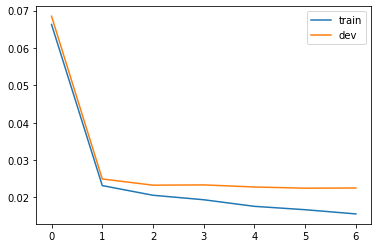

In [110]:
plt.plot(training_losses, label='train')
plt.plot(dev_losses, label='dev')
plt.legend()
plt.show()

### Test set evaluation

In [112]:
del training_data_full, dev_data_full, train_set_orig

In [111]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('training_data_full', 2846186448),
 ('dev_data_full', 1219792680),
 ('customers', 242840620),
 ('train_set_orig', 221373040),
 ('purchases_by_customer_id_idx', 164879592),
 ('train_set', 145325160),
 ('train_set_processed', 145325160),
 ('articles_df', 125930965),
 ('test_set', 8941805),
 ('article_id_to_idx', 5242984),
 ('dev_set', 3057288),
 ('unique_customers_df', 1114328),
 ('dev_set_by_customer', 447058),
 ('customer_id_to_idx', 295016),
 ('article_id_idx_to_keep', 223704),
 ('customer_id_idx_ordered', 15576),
 ('dev_actuals', 15576),
 ('top100_items', 8072),
 ('customers_to_remove', 2280),
 ('DataLoader', 1472),
 ('FashionRecV2', 1472),
 ('MinMaxScaler', 1472),
 ('PurchasesDatasetWithArticleFeatures', 1472),
 ('SimpleImputer', 1192),
 ('Dataset', 1064),
 ('cat_code_to_indices', 656),
 ('data', 272),
 ('customers_cat_code_to_indices', 248),
 ('CATEGORICAL_FEATURES', 168),
 ('mapk', 144),
 ('negative_samples', 144),
 ('train_test_split', 144),
 ('NUMERIC_FEATURES', 136),
 ('dev_l

In [113]:
test_set['article_id_idx'] = test_set['article_id'].map(article_id_to_idx)

In [114]:
test_set_by_customer = test_set.groupby('customer_id').apply(lambda x: list(x['article_id_idx'])).reset_index().rename(columns={0: 'article_id_idx'})
test_set_by_customer.head()

,customer_id,article_id_idx
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[78503]
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[74893, 74893, 24872, 104987, 9801, 9801, 6912..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[92815, 86041]"
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[104211, 17044, 17044, 16024, 29250, 98445, 66..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[87467, 99966, 42626, 79834, 97540, 103280, 79..."


In [115]:
test_set.shape

(32995, 6)

In [116]:
training_data_full.head()

NameError: ignored

In [117]:
top100_items = (train_set.groupby('article_id_idx')['customer_id'].count() / train_set.shape[0]).sort_values(ascending=False).head(2000).index.tolist()

In [118]:
test_data = test_set_by_customer.copy()[['customer_id']]
test_data['customer_id_idx'] = test_data['customer_id'].map(customer_id_to_idx)
test_data.drop(columns='customer_id', inplace=True)
test_data.head()

,customer_id_idx
0,0
1,4003
2,238
3,3419
4,7876


In [119]:
test_data['join_key'] = 1

In [120]:
top100_items_df = pd.DataFrame({'article_id_idx': top100_items})
top100_items_df['join_key'] = 1
top100_items_df.head()

,article_id_idx,join_key
0,53892,1
1,53893,1
2,1713,1
3,24837,1
4,70221,1


In [121]:
test_data = test_data.merge(top100_items_df, on='join_key').drop('join_key', axis=1)

In [122]:
test_data.head()

,customer_id_idx,article_id_idx
0,0,53892
1,0,53893
2,0,1713
3,0,24837
4,0,70221


In [123]:
test_data['article_id_idx'] = np.random.choice(len(article_id_to_idx), replace=True, size=test_data.shape[0])

In [ ]:
test_data = test_data.merge(articles_df[['article_id_idx'] + CATEGORICAL_FEATURES], on=['article_id_idx'])

In [123]:
test_data = test_data.merge(
    customers.drop(columns='customer_id'),
    on='customer_id_idx'
)

In [124]:
test_data.shape

(9208000, 20)

In [125]:
endm1

Timestamp('2020-09-07 00:00:00')

In [126]:
set(training_data_full.columns) - set(test_data.columns)

{'example_age',
 'purchased',
 't_dat_quarter_1',
 't_dat_quarter_2',
 't_dat_quarter_3',
 't_dat_quarter_4'}

In [127]:
test_data['example_age'] = -0.001
test_data['purchased'] = 999
test_data['t_dat_quarter_1'] = 0
test_data['t_dat_quarter_2'] = 0
test_data['t_dat_quarter_3'] = 1
test_data['t_dat_quarter_4'] = 0

In [128]:
test_dataset = PurchasesDatasetWithArticleFeatures(test_data)

In [129]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*4)  

In [130]:
test_predictions = []

fashion_rec_v2.eval()

with torch.no_grad():
    for data in tqdm(test_loader):

        user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = data
        
        user_id, item_id, product_code, product_type_no, product_group_no, graphical_appearance_no, colour_group_code, perceived_colour_value_id, perceived_colour_master_id, department_no, index_code, index_group_no, section_no, garment_group_no, club_member_status, fashion_news_frequency, postal_code, numeric_features, label = (
            user_id.to(device), 
            item_id.to(device), 
            product_code.to(device), 
            product_type_no.to(device), 
            product_group_no.to(device), 
            graphical_appearance_no.to(device), 
            colour_group_code.to(device), 
            perceived_colour_value_id.to(device), 
            perceived_colour_master_id.to(device), 
            department_no.to(device), 
            index_code.to(device), 
            index_group_no.to(device), 
            section_no.to(device), 
            garment_group_no.to(device), 
            club_member_status.to(device), 
            fashion_news_frequency.to(device), 
            postal_code.to(device), 
            numeric_features.to(device),
            label.to(device)
        )    

        optimizer.zero_grad()  # Set gradients to 0 otherwise will accumulate

        pred = fashion_rec_v2(
            user_id, 
            item_id, 
            product_code, 
            product_type_no, 
            product_group_no, 
            graphical_appearance_no, 
            colour_group_code, 
            perceived_colour_value_id, 
            perceived_colour_master_id, 
            department_no, 
            index_code, 
            index_group_no, 
            section_no, 
            garment_group_no,
            club_member_status,
            fashion_news_frequency,
            postal_code,
            numeric_features.float()
        )
        
        test_predictions += pred.flatten().tolist()

100%|██████████| 1125/1125 [02:15<00:00,  8.29it/s]


In [131]:
len(test_predictions)

9208000

In [132]:
len(test_dataset)

9208000

In [133]:
test_data['prediction'] = test_predictions

In [134]:
test_data.sort_values(['customer_id_idx', 'prediction'], ascending=False, inplace=True)

In [135]:
test_data_top12 = test_data.groupby('customer_id_idx').head(12).groupby('customer_id_idx').apply(lambda x: list(x['article_id_idx'])).reset_index().rename(columns={0: 'predictions'})
test_data_top12

,customer_id_idx,predictions
0,0,"[58491, 79438, 39738, 22473, 14748, 40449, 775..."
1,1,"[77315, 367, 14259, 75912, 80186, 28895, 2188,..."
2,2,"[67522, 95065, 74921, 41954, 100136, 26609, 20..."
3,3,"[62837, 91321, 102850, 38639, 36613, 100641, 1..."
4,4,"[2260, 46425, 1823, 53896, 56691, 17396, 39541..."
...,...,...
9203,9203,"[22466, 99, 32719, 71087, 55504, 72634, 42850,..."
9204,9204,"[88489, 54660, 19221, 59597, 84864, 9613, 7361..."
9205,9205,"[24288, 54228, 87929, 11354, 80375, 42293, 606..."
9206,9206,"[78282, 67246, 79318, 58586, 78232, 75450, 876..."


In [136]:
test_set_by_customer['customer_id_idx'] = test_set_by_customer['customer_id'].map(customer_id_to_idx)

In [137]:
test_set_by_customer.head()

,customer_id,article_id_idx,customer_id_idx
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[78503],0
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[74893, 74893, 24872, 104987, 9801, 9801, 6912...",4003
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[92815, 86041]",238
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[104211, 17044, 17044, 16024, 29250, 98445, 66...",3419
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[87467, 99966, 42626, 79834, 97540, 103280, 79...",7876


In [138]:
test_set_by_customer = test_set_by_customer.merge(test_data_top12, on='customer_id_idx')
test_set_by_customer.head()

,customer_id,article_id_idx,customer_id_idx,predictions
0,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,[78503],0,"[58491, 79438, 39738, 22473, 14748, 40449, 775..."
1,0015f37f752a41a75c3be6f3f92deedc4c87d039f1758e...,"[74893, 74893, 24872, 104987, 9801, 9801, 6912...",4003,"[55738, 18295, 18295, 25408, 76768, 52946, 404..."
2,00282135561702f5b3b750fa3382d8fd83ce5d761a507e...,"[92815, 86041]",238,"[75828, 69825, 10771, 68851, 101242, 80270, 26..."
3,00356a94bb9bed341f6dba58ad722974b01a1cbd9f06ef...,"[104211, 17044, 17044, 16024, 29250, 98445, 66...",3419,"[38609, 12202, 32844, 217, 78649, 61050, 40994..."
4,00462904b288681a9facb555f75dd2cf4d0f730a6e0ea7...,"[87467, 99966, 42626, 79834, 97540, 103280, 79...",7876,"[53893, 77315, 37918, 46426, 898, 60237, 26266..."


In [139]:
predictions = test_set_by_customer['predictions'].to_list()

In [140]:
actuals = test_set_by_customer['article_id_idx'].to_list()

In [141]:
mapk(actuals, predictions, k=12)

0.00034766036205002317

In [142]:
test_set_by_customer['predictions'].astype(str).nunique()

9208

In [143]:
test_set_by_customer.shape

(9208, 4)

In [144]:
most_pop_12 = (train_set.groupby('article_id_idx')['customer_id'].count()).sort_values(ascending=False).head(12).index.to_list()
most_pop_12 = set(most_pop_12)
most_pop_12

{1713,
 1714,
 2236,
 3091,
 24836,
 24837,
 42626,
 53892,
 53893,
 58491,
 67522,
 70221}

In [145]:
test_set_by_customer['num_top_12_items'] = test_set_by_customer['predictions'].apply(lambda x: len(set(x).intersection(most_pop_12)))

In [146]:
test_set_by_customer['num_top_12_items'].value_counts().sort_index()

0    8453
1     714
2      39
3       2
Name: num_top_12_items, dtype: int64

Observations:
- Using the same embedding dimension for all embeddings the model learns the most popular items and predominantly selects those for its recommendations. The recommendations are also ordered in the same way for the majority of customers, highlighting a lack of differentiation. Q: Can we encourage more diversity by increasing the dimension of the user and/or item embeddings?

Questions:
- How often do customers purchase something they purchased before? __A__: train -> dev (12%), train+dev -> test (10%)
- How similar are purchases to previous items (sample and see)?
- Proportion of purchases accounted for by top-X items (e.g. we know top-1000 is around 10% of purchases in dev set)